<header style="background-color: rgb(0, 62, 92); color: white; margin-top: 20px; padding:28px; ">
  <img src="images/Xlogo.png" alt="Transposition of a vector" title="Vector transposition" width="115" style="float: left;">
  <p style=" text-align: center; font-size: 32px;">   
   <strong> Fractional and Volterra processes in Finance  </strong></p>
  <p style=" text-align: center; font-size: 25px;"><strong> Pricing by Fourier </strong></p>
</header>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.special as sc
import pandas as pd
import cmath
import time
from scipy.stats import norm
from scipy.special import gamma, gammainc, hyp2f1, roots_laguerre
from scipy.optimize import minimize, fsolve, brentq, fmin
from scipy.integrate import quad, quadrature, quad_vec
from scipy.interpolate import griddata, interp1d, CubicSpline, PchipInterpolator
from numpy.random import default_rng

rng = default_rng()

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">1. Heston</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<p  style="background-color: rgb(0, 62, 92); color: white; text-align: center; font-size: 15px;"><strong> </strong></p> 

1. Implement the characteristic function of the conventional Heston model
\begin{align*}
	dS_t &=S_t \sqrt{V_t} dB_t, \quad d\langle W, B\rangle_t = \rho dt \\
	dV_t &= (\theta-\kappa V_t)dt + \eta \sqrt{V_t} dW_t, \quad V_0 \geq 0, S_0=1
\end{align*}
    
Denote by 
$$ \Phi_{T}(z) = \mathbb E\left[ \exp\left( \mathrm i z \log S_T \right) \right]$$

2. Price Put options pricer using  Lewis inversion formula
$$ \mathbb E (K-S_T)^+ = K - \frac {\sqrt{S_0K}}{\pi } \int_{\mathbb R_+} \Re \left(e^{izk} \frac{\Phi_T(z-\frac{i}{2})}{z^2 + \frac 1 4 }\right) dz,$$
with $k=\log(S_0/K)$.

3. Plot implied vol surface (slice by slice for different maturity slices $T$ ranging from 0.02 to 1)

4. Set $\kappa=\eta=1/\epsilon$ and plot the atm skew as $\epsilon \to 0$ and comment.  


Calls are obtained by Put call parity (r=0).


To sanity check your code here are two value of references for prices of call.

Recall: 

**Theorem.** (Characteristic function in Heston model) For $v \in \mathbb{R}$, 
$$
\mathbb{E}[\exp(iv \log S_T) \mid \mathcal{F}_t] = \exp\left( iv \log S_t + \phi(T - t) + \psi(T - t) V_t \right),
$$

with 

$$ \psi(t) = \frac{\beta(v) - D(v)}{\eta^2} \frac{1 - e^{-D(v)t}}{1 - G(v) e^{-D(v)t}} $$

$$ \phi(t) = \frac{\theta}{\eta^2} \left( (\beta(v) - D(v)) t - 2 \log \left( \frac{G(v) e^{-D(v)t} - 1}{G(v) - 1} \right) \right) $$

$$ \beta(v) = \kappa - iv \rho \eta $$

$$ D(v) = \sqrt{\beta(v)^2 + \eta^2 v(i + v)} $$

$$ G(v) = \frac{\beta(v) - D(v)}{\beta(v) + D(v)} $$


In [2]:
V0 = 0.0175
kappa = 1.5768
theta = 0.0398*1.5768
rho = -0.5711
sigma = 0.5751
eta = sigma

r = 0.
K = 1. 
S0 = 1.

ref_value_T1y = 0.05785155435  #See fang osterlee p15
ref_value_T10y = 0.22318945791474590  #See fang osterlee p15 

#### **Answer 1.** Implemention of the characteristic function of the conventional Heston model

We implement the functions in such a way to avoid as much as possible to recompute some basic functions ($\beta$, $D$ and $G$) to easy ameliorate computational time.

More over, we code for the case that $t=0$ 

In [3]:
def beta(v, eta=eta, kappa=kappa, rho=rho):
    return kappa - v*rho*eta * 1j

def D(v, b_v, eta=eta):
    return np.sqrt( b_v**2 + eta**2*v*(1j + v) )

def G(b_v, d_v):
    return (b_v-d_v)/(b_v+d_v)

def phi(t, b_v, d_v, g_v, eta=eta, theta=theta):
    return (theta / eta**2) * ((b_v - d_v) * t - 2 * np.log((g_v * np.exp(-d_v * t) - 1) / (g_v - 1)))

def psi(t, b_v, d_v, g_v, eta=eta):
    return (b_v - d_v) / eta**2 * (1 - np.exp(-d_v * t)) / (1 - g_v * np.exp(-d_v * t))

def Phi_Heston(z, T, V0=V0, S0=S0, eta=eta, kappa=kappa, rho=rho, theta=theta):
    b_z = beta(z, eta, kappa, rho)
    d_z = D(z, b_z, eta)
    g_z = G(b_z, d_z)
    phi_z = phi(T, b_z, d_z, g_z, eta, theta)
    psi_z = psi(T, b_z, d_z, g_z, eta)
    return np.exp(1j*z*np.log(S0) + phi_z + psi_z*V0)

#### **Answer 2.** Price of Put options pricer using  Lewis inversion formula

Here, we implement the **Lewis formula** that aims at calculating the european $Put$ price. We use a **Gauss-Laguerre quadrature**.

For sanity check, we use the $Call-Put$ parity for european options given by:

$$ Call(T, K) = Put(T, K) + S_0 - K e^{-rT} $$

In [4]:
def Put_price_lewis(T, K, V0=V0, S0=S0, eta=eta, kappa=kappa, rho=rho, theta=theta):
    """ Compute the put price under the Volterra-Heston model using the Lewis formula """
    n_points = 184
    k = np.log(S0/K)
    z_hest, w_hest = np.polynomial.laguerre.laggauss(n_points)
    char_func_hest = Phi_Heston(z_hest-1j/2, T, V0, S0, eta, kappa, rho, theta)
    integrand_heston = np.real( np.exp(1j * z_hest * k) * char_func_hest ) / (z_hest**2 + 1/4)
    integral = np.sum(integrand_heston*np.exp(z_hest)*w_hest)
    return K - (np.sqrt(S0 * K) / np.pi) * integral 
    
    
def Call_price_parity(Put, T, K, S0=S0, r=0):
    """ Deduces the call price using the Call-Put parity """
    Call = Put + S0 - K*np.exp(-r*T)
    return Call

#### Sanity check of prices

In [5]:
T_check = np.array([1, 10])
Put_prices_lew = np.array([Put_price_lewis(T0, K) for T0 in T_check])
Call_prices_lew = Call_price_parity(Put_prices_lew, T_check, K)
ref_values = np.array([ref_value_T1y, ref_value_T10y])
sanity_check = pd.DataFrame({'T(Y)': T_check, 'Lewis Call price': Call_prices_lew, 'ref_value':ref_values})
sanity_check

,T(Y),Lewis Call price,ref_value
0,1,0.057852,0.057852
1,10,0.223189,0.223189


##### **Comments**: The results given by the implement code perfectly fit the given reference values

#### **Answer 3.** Implied vol surface for $T \in [0.02, 1]$.

To calculate the implied volatility $\sigma_{implied}(T, K)$ at a fixed $(T, K)$, we find the (positive) zero of :

$$ 
f_{T, K}(\sigma) = Put^{BS}(\sigma, T, K) - Put^{Lewis}(T, K) \quad \text{or equivalently} \quad Call^{BS}(\sigma, T, K) - Call^{Lewis}(T, K)
$$

In [6]:
def blackscholes_price(vol, T, K, S0=S0, r=r, callput='call'):
    """ Computes the BS price of a Call/ Put option """
    F = S0*np.exp(r*T)
    v = vol*np.sqrt(T)
    d1 = np.log(F/K)/v + 0.5*v if v > 1e-12 else np.sign(np.log(F/K)) * np.inf
    d2 = d1 - v
    try:
        opttype = {'call':1, 'put':-1}[callput.lower()]
    except:
        raise ValueError('The value of callput must be either "call" or "put".')
    price = opttype*(F*norm.cdf(opttype*d1)-K*norm.cdf(opttype*d2))*np.exp(-r*T)
    return price

In [7]:
def implied_vol(T, K, V0=V0, S0=S0, r=r, eta=eta, kappa=kappa, rho=rho, theta=theta):
    """ Computes the implied volatility under the Heston model """
    lewis_put = Put_price_lewis(T, K, V0, S0, eta, kappa, rho, theta)
    def objective(vol):
        BS_price = blackscholes_price(vol, T, K, S0, r, 'put')
        return BS_price-lewis_put
    
    try:
        return brentq(objective, 1e-6, 5, xtol=1e-6, maxiter=100)
    except ValueError:
        return np.nan 

In [8]:
T_list = np.array([0.02, 0.04, 0.1, 0.25, 0.5, 1.])
K_list = np.linspace(np.exp(-0.5), np.exp(0.5), 80)
implied_vol_list = np.array( [ [implied_vol(T0, K0) for K0 in K_list] for T0 in T_list ] )

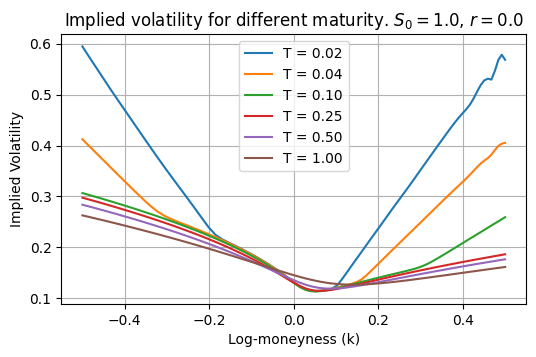

In [9]:
plt.figure(figsize=(6, 3.5))
for i, T0 in enumerate(T_list):
    vol_row = implied_vol_list[i, :]
    valid = ~np.isnan(vol_row)
    if np.sum(valid) < 2:
        continue
    f_interp = interp1d(K_list[valid], vol_row[valid], kind='linear', bounds_error=False, fill_value="extrapolate")
    vol_interp = f_interp(K_list)
    plt.plot(np.log(K_list), vol_interp, label=f"T = {T0:.2f}")
plt.xlabel("Log-moneyness (k)")
plt.ylabel("Implied Volatility")
plt.title(f"Implied volatility for different maturity. $S_0={S0}$, $r={r}$")
plt.legend()
plt.grid(True)
plt.show()

#### **Comment:** We observe implied volatility curves that:

- First decrease and then increase, showing strong asymmetry.
- Are higher for deep ITM and deep OTM options.
- Different behaviour of the smile for very short maturities. This may be because the Heston model is based on mean reversion assumptions for volatility, meaning that volatility reverts to a long-term average. However, over very short time horizons, this reversion may not be sufficient to realistically model volatility behavior.

#### **Answer 4.** Atm skew for $\kappa=\eta=1/\epsilon$ and plots as $\epsilon \to 0$

The $ATM$ skew is guiven by the formula:

$$
\text{Skew}_{ATM} (T) = - \left. \frac{\partial \sigma_{implied}(T, S_0 e^x)}{\partial x} \right|_{x=0} \quad \text{with} \quad x = \log(\frac{K}{S_0})
$$

We use a **finite difference approach** to approximate derivation for some $\Delta x$ small enough:

$$
\begin{aligned}
\text{Skew}_{ATM} (T) &\approx - \left. \frac{\sigma_{implied}(T, S_0 e^{x+\Delta x}) - \sigma_{implied}(T, S_0 e^{x-\Delta x})}{2\Delta x} \right|_{x=0} \\
                    &\approx - \frac{\sigma_{implied}(T, S_0 e^{\Delta x}) - \sigma_{implied}(T, S_0 e^{-\Delta x})}{2\Delta x}
\end{aligned}
$$


In [10]:
def skew_atm(T, V0=V0, S0=S0, r=r, eta=eta, kappa=kappa, rho=rho, theta=theta, delta_x=1e-5):
    """ Compute the skew atm under the Heston model """
    K_plus = S0 * np.exp(delta_x)   
    K_minus = S0 * np.exp(-delta_x) 
    sigma_plus = implied_vol(T, K_plus, V0, S0, r, eta, kappa, rho, theta)
    sigma_minus = implied_vol(T, K_minus, V0, S0, r, eta, kappa, rho, theta)
    skew_atm = -(sigma_plus - sigma_minus) / (2 * delta_x)
    return skew_atm

In [11]:
T_list = np.linspace(0.02, 1, 50)
eps_list = np.array([1e-5, 1e-6, 1e-7, 1e-8])
skew_atm_list = np.array( [ [ skew_atm(t, V0, S0, r, 1/eps, 1/eps) for t in T_list ] for eps in eps_list] )

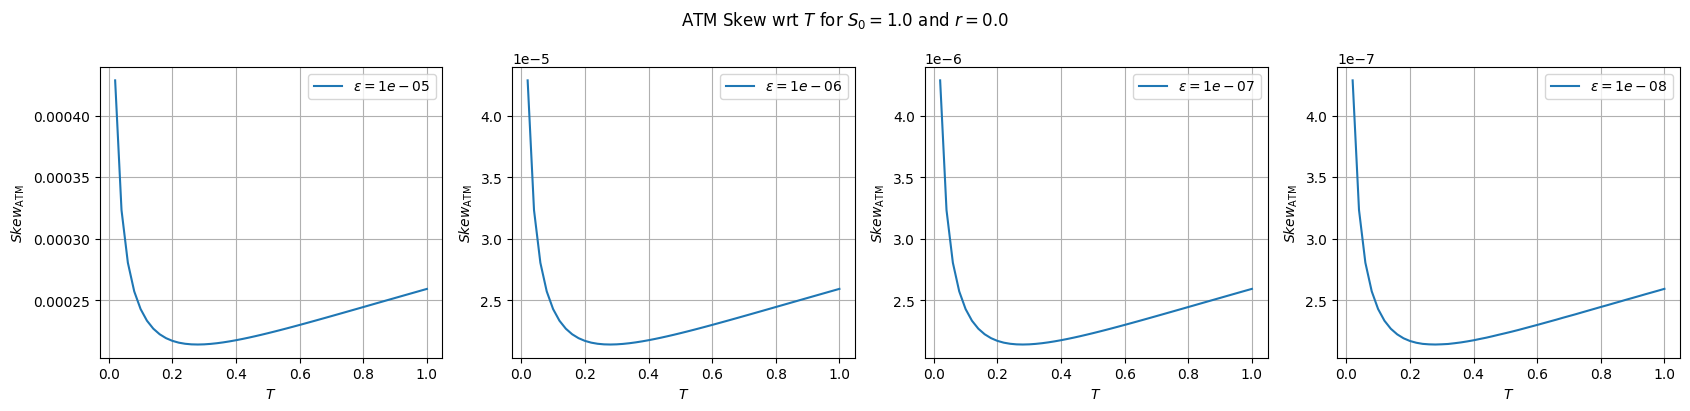

In [12]:
fig, axs = plt.subplots(1, len(eps_list), figsize=(17, 4.15))
for i, eps in enumerate(eps_list):
    axs[i].plot(T_list, skew_atm_list[i], label=f"$\\epsilon = {eps}$")
    axs[i].set_xlabel("$T$")
    axs[i].grid()
    axs[i].legend()
    axs[i].set_ylabel(r"$Skew_{\text{ATM}}$")
fig.suptitle(f"ATM Skew wrt $T$ for $S_0={S0}$ and $r={r}$")
plt.tight_layout()
plt.show()

##### **Comments :** 
- The ATM explodes as $T \to 0$
- The ATM Skew globally vanishes as $\epsilon \to 0$ (It becomes $< 10^{-7}$)
- The ATM Skew decreases for short $T$ and then increases. Under the Heston model, the skew decreases rapidly for short maturities because the instantaneous variance $V_0$ dominates, and volatility has not yet had time to revert to its mean. For longer maturities, mean reversion stabilizes volatility, reducing the effect of the correlation $\rho$ which leads to a slower increase in skew.

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">2. Volterra Heston</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<p  style="background-color: rgb(0, 62, 92); color: white; text-align: center; font-size: 15px;"><strong>  </strong></p>

1. Do the same thing for Volterra Heston model:
Heston by a fractional one:
\begin{align*}
	dS_t &= S_t \sqrt{V_t} dB_t, \quad S_0=1,\\
	V_t &= V_0 + \int_0^t   K_{\epsilon}(t-s) \left(  ( \theta - \lambda V_s) ds +  \eta  \sqrt{V_s} dW_s \right),
\end{align*}
with $K_{\epsilon}(t) = {{(t +\epsilon)}^{H-1/2}}$

by implementing the Adam Scheme (or any other scheme) for the Riccati Volterra equation

2.  Plot the volatility surface for with $T=\{0.02, 0.04, 0.1, 0.25, 0.5, 1. \}$
and parameters:

$$ \lambda = 0, \quad    \rho=-0.7, \quad \theta=0.02, \quad \eta=0.3, \quad V_0=0.02, \quad H=0.1 $$

3. For fixed $\epsilon =0$, make $H$ vary and plot the atm-skew between 1 week and 1 year for varying $H$ and comment
4. For fixed $H=0.01$ make $\epsilon$ vary and plot the atm-skew between 1 week and 1 year  and comment. 
5. Which model seems more suited for the market? argue. 
 

In [13]:
S0 = 1.
V0 = 0.02 
K = 1.

#### Volterra Heston model parameters
lambd = 0.0
rho = -0.7
theta = 0.02
eta = 0.3
H = 0.1

#### Pure Heston model parameters
V0_h = 0.0175
kappa_h = 1.5768
theta_h = 0.0398*1.5768
rho_h = -0.5711
eta_h = 0.5751

#### **Answer 1:** Semi-implicite scheme + Multi factor approximation of the kernel for Riccati Volterra equation.

The Riccati Volterra equations are given by:

$$
\psi(t) = \int_0^t K_{\epsilon}(t - s) F(\psi(s)) \, ds
$$

$$
F(\psi) = \frac{1}{2} \left( z^2 - z \right) + (z \rho \eta - \lambda) \psi + \frac{1}{2} \eta^2 \psi^2
$$

Using the **Multi Factor** approach, let's approximate $K_{\epsilon}(t)$ by:

$$K^N_{\epsilon}(t) = \sum_{i=1}^N c_i(\epsilon) e^{-x_i t}$$

With the following parametrization ($\alpha = H + \frac{1}{2}$) : 

$$
c^N_i (\epsilon) =
\begin{cases} 
\frac{(r_N^{(1-\alpha)} - 1) r_N^{(\alpha-1)(1+N/2)}}{\Gamma(1-\alpha)(1-\alpha)} r_N^{(1-\alpha)i} & \text{if } \epsilon = 0 \\[10pt]
(r_N^{(1-\alpha)} - 1) r_N^{(\alpha-1)(1+N/2)} r_N^{(1-\alpha)i} \times \left( \epsilon r_N^{N/2} \right)^{\alpha - 1}  & \text{if } \epsilon > 0.
\end{cases}
$$

$$
x^N_i = \frac{1-\alpha}{2-\alpha} \frac{r_N^{2-\alpha} - 1}{r_N^{1-\alpha} - 1} r_N^{i-1-N/2}
$$

For some $r_N$ to find such that  

$$ r_N \downarrow 1 \quad \text{et} \quad N \ln r_N \to \infty, \quad \text{lorsque } N \to \infty. $$

This is done by minimizing :

$$\int_0^T \left| K^N_{\epsilon}(t) - K_\epsilon(t) \right|^2 dt$$

So, all calcultions done the function to minimize is:

$$
\int_0^T \left| K^N_{\epsilon}(t) - K_\epsilon(t) \right|^2 dt = \sum_{i=1}^N \sum_{j=1}^N c_i c_j \frac{1 - e^{-(x_i + x_j)T}}{x_i + x_j} -2 \sum_{i=1}^N \frac{c_i}{x_i^{\alpha}} e^{x_i\epsilon} \left[ \gamma(\alpha, x_i (\epsilon + T)) - \gamma(\alpha, x_i \epsilon) \right] + \left[ \frac{(\epsilon + T)^{2\alpha - 1}}{2\alpha - 1} - \frac{\epsilon^{2\alpha - 1}}{2\alpha - 1} \right]
$$

Where $\gamma(\alpha, x) = \int_0^x t^{\alpha-1} e^{-t}dt$ is the incomplete gamma function.

With this approximated kernel, The Riccati Volterra equations are given by:

$$
\psi(t) \approx \int_0^t K^N_{\epsilon}(t - s) F(\psi(s)) \, ds
$$

$$
F(\psi) = \frac{1}{2} \left( z^2 - z \right) + (z \rho \eta - \lambda) \psi + \frac{1}{2} \eta^2 \psi^2
$$

Applying the Leibniz rule, we have:

$$
\psi'(t) = K^N_{\epsilon}(0)\,F(\psi(t)) + \int_0^t \left(K^N_{\epsilon}\right)'(t-s)\,F(\psi(s))\,ds.
$$

Let's $k_0 = K^N_{\epsilon}(0)$.

For a uniform discretization in time ( $t_i = idt$ with $dt = \frac{T}{n}$), the **Semi-implice scheme** that has been used is the following:

$$
\frac{\psi(t_{i+1}) - \psi(t_{i})}{dt} = k_0\,F(\psi(t_{i+1})) + \int_0^{t_{i+1}} \left(K^N_{\epsilon}\right)'(t_{i+1}-s)\,F(\psi(s))\,ds.
$$

To compute the integrals $\int_0^{t_{i+1}} \left(K^N_{\epsilon}\right)'(t_{i+1}-s)\,F(\psi(s))\,ds$, we use the following scheme:


$$ 
\begin{aligned}
\int_0^{t_{i+1}} \left(K^N_{\epsilon}\right)'(t_{i+1}-s)\,F(\psi(s))\,ds &\approx \sum_{j=0}^{i} \frac{F(\psi(t_{j+1}))+F(\psi(t_j))}{2} \int_{t_j}^{t_{j+1}} \left(K^N_{\epsilon}\right)'(t_{i+1}-s) \, ds \\
            &= \sum_{j=0}^{i} w^{i+1}_j \frac{F(\psi(t_{j+1}))+F(\psi(t_j))}{2} 
\end{aligned}
$$

Where $w_j^i$ for $j \in (0, ..., i-1)$ are weights with the closed expression:

$$ 
\begin{aligned}
w_j^i &= \int_{t_j}^{t_{j+1}} \left(K^N_{\epsilon}\right)'(t_{i}-s) \, ds \\ 
    &= K^N_{\epsilon}(t_i - t_j) - K^N_{\epsilon}(t_i - t_{j+1}) 
\end{aligned}
$$

The final scheme is as follows : 

$$
\frac{\psi(t_{i+1}) - \psi(t_{i})}{dt} = k_0\,F(\psi(t_{i+1})) + \sum_{j=0}^{i} w^{i+1}_j \frac{F(\psi(t_{j+1}))+F(\psi(t_j))}{2}
$$

It implies to find the roots of a polynomial function of degre 2.

$$
A\,\psi(t_{i+1})^2 + B\,\psi(t_{i+1}) + C = 0,
$$

where

$$
\begin{aligned}
A &= c\,dt\left[k_0 + \frac{w^{i+1}_i}{2}\right], \\[1mm]
B &= b\,dt\left[k_0 + \frac{w^{i+1}_i}{2}\right] - 1, \\[1mm]
C &= \psi(t_i) + dt\left[k_0 a + \frac{a w^{i+1}_i}{2}\right]
+ \frac{dt}{2} \left(\sum_{j=0}^{i} w^{i+1}_j\,F(\psi(t_j))
+ \sum_{j=0}^{i-1} w^{i+1}_j\,F(\psi(t_{j+1}))\right) \\

a &= \frac{1}{2} (z^2 - z) \quad b = z \rho \eta - \lambda \quad c = \frac{1}{2} \eta^2.
\end{aligned}
$$

This equation always has a complex solution. In case there are two solutions, the solution choosen for $\psi(t_{i+1})$ is the one which closest from $\psi(t_{i})$

In [14]:
n = 200 # discretization step
n_min = 150
N = 20  # Number of factors

In [15]:
######################################## Multi - factor kernel ######################################
def compute_c(alpha, r, N, eps):
    A = r**(1-alpha) - 1
    B = r**((alpha-1)*(1+N/2))
    C = gamma(1-alpha)*(1-alpha)
    D = r**((1-alpha)*np.arange(1,N+1))
    res = (A*B/C)*D
    if eps>0:
        res = res * (1-alpha)*gamma(1-alpha) * ( eps * r**(N/2) )**(alpha-1)
    return res.astype(np.float64)

def compute_x(alpha, r, N):
    A = (1-alpha)/(2-alpha)
    B = (r**(2-alpha)-1)/(r**(1-alpha)-1)
    C = r**(np.arange(1,N+1)-1-N/2)
    res = A*B*C
    return res.astype(np.float64)

def gamma_integral(a, b, alpha):
    return gamma(alpha) * (gammainc(alpha, b) - gammainc(alpha, a))

def find_r_shift(N, H, T, eps):
    alpha = H + 0.5
    def objective(r):
        c = compute_c(alpha, r, N, eps)
        x = compute_x(alpha, r, N)
        c, x = c[:, None], x[:, None]   
        c_product = c * c.T 
        x_sum = x + x.T   
        exp_x_eps = 1 + x*eps + 0.5*(x*eps)**2 + (1/6)*(x*eps)**3 + (1/24)*(x*eps)**4
        term1 = np.sum(c_product*(1-np.exp(-(x_sum)*(T)))/x_sum)
        term2 = -2*np.sum( exp_x_eps * (c/x**alpha) * gamma_integral(x*eps, x*(T+eps), alpha) )
        term3 = ((T+eps)**(2*alpha-1) - eps**(2*alpha-1))/(2*alpha-1)
        return term1+term2+term3
    result = minimize(objective, x0=2.0, bounds=[(1+1e-6, None)], method='Nelder-Mead')
    r = result.x[0]
    norm2 = objective(r)
    return r, norm2

def K_eps_N(t, eps, c, x):
    t = np.array([t]) if not isinstance(t, np.ndarray) else t
    K = np.sum( c[None,:]*np.exp(-x[None,:]*(t[:,None])), axis=1)
    if K.shape == (1,):
        return K.item()
    return K

def weight_approx(t, i, j, eps, c, x):
    return K_eps_N(t[i]-t[j], eps, c, x) - K_eps_N(t[i]-t[j+1], eps, c, x)


######################################## Initial truncated kernel ######################################
def K_eps(t, eps, H=H, tol=0.5e-14):
    t = np.array([t]) if not isinstance(t, np.ndarray) else t
    if eps == 0:
        shift = np.where(t==0, tol, 0)
    else:
        shift = eps * np.ones_like(t)
    K = (t + shift) ** (H - 0.5)
    if K.shape == (1,):
        return K.item()
    return K


def weight(t, i, j, eps, H=H):
    return K_eps(t[i]-t[j], eps, H) - K_eps(t[i]-t[j+1], eps, H)



############################### F function ##############################################
def F_fun(psi, z, lambd=lambd, rho=rho, eta=eta):
    return 0.5*(z**2 - z) + (z*rho*eta - lambd)*psi + 0.5*(eta**2)*(psi**2)
    

In [16]:

def Riccati_solver(z, T, eps, approx, N, H=H, lambd=lambd, rho=rho, eta=eta, n=n):
    """ Solves the Riccati-Voterra equation and outputs the function psi(t) for many values of z"""
    z = np.asarray(z)  
    m = len(z)  
    n = int(max(n_min, n*T))
    dt = T/n
    t = np.linspace(0, T, n+1)
    
    r, _ = find_r_shift(N, H, T, eps)
    c1 = compute_c(H+0.5, r, N, eps)
    x = compute_x(H+0.5, r, N)
    a, b, c = 0.5*(z**2 - z), z*rho*eta - lambd, 0.5*eta**2

    k0 = K_eps_N(0, eps, c1, x) if approx else K_eps(0, eps, H)
    psi_t = np.zeros((m, n+1), dtype=complex)
    F_psi_t = np.zeros((m, n+1), dtype=complex)
    F_psi_t[:, 0] = F_fun(psi_t[:, 0], z, lambd, rho, eta)
    for i in range(0, n):
        if approx:
            w = np.array([weight_approx(t, i+1, j, eps, c1, x) for j in range(0, i+1)]) 
        else :
            w = np.array([weight(t, i+1, j, eps, H=H) for j in range(0, i+1)])
            
        integ_1 = np.sum(w[None,:] * F_psi_t[:,:i+1], axis=1)  
        integ_2 = np.sum(w[None,:i] * F_psi_t[:, 1:i+1], axis=1) if i > 0 else np.zeros(m)

        coef2 = k0*c*dt + c*w[-1]*dt/2  
        coef1 = k0*b*dt + b*w[-1]*dt/2 - 1  
        coef0 = psi_t[:, i] + k0*dt*a + (integ_1 + integ_2)*dt/2 + a* w[-1]*dt/2  
        roots = np.array([np.roots([coef2, coef1[j], coef0[j]]) for j in range(m)])  

        psi_t[:, i+1] = np.array([roots[j, np.argmin(np.abs(roots[j] - psi_t[j, i]))] for j in range(m)])
        F_psi_t[:, i+1] = F_fun(psi_t[:, i+1], z, lambd, rho, eta)

    return t, psi_t


##### Here are some plots of $\Re(\psi_t)$ for $z = i \, u$ with $u \in \R_+$ for $\epsilon = 0$ and $\epsilon > 0$

We plot for both kernels :

- Approximated kernel $K^{N}_{\epsilon}$
- Initial kernel $K_{\epsilon}$. In this cas, for $\epsilon=0$, we add a tolerance of $10^{-14}$ at $t=0$ to avoid explosion

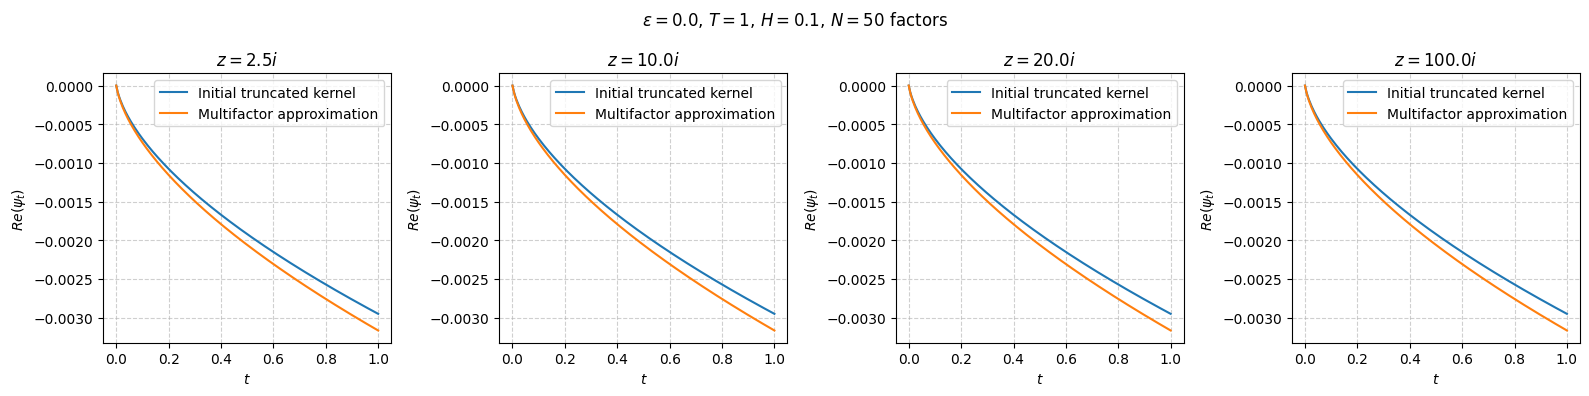

In [17]:
u_list = np.array([2.5, 10, 20, 100])
T = 1
eps = 0.0
N = 50
H = 0.1
t = np.linspace(0, T, int(max(n_min, n*T))+1)
psi_t_list = Riccati_solver(1j*u_list, T, eps, False, N, H)[1]
psi_t_list_approx = Riccati_solver(1j*u_list, T, eps, True, N, H)[1] 
fig, axs = plt.subplots(1, len(u_list), figsize=(16, 4))
for i, u in enumerate(u_list):
    axs[i].plot(t, np.real(psi_t_list[i]), label=f'Initial truncated kernel')
    axs[i].plot(t, np.real(psi_t_list_approx[i]), label=f'Multifactor approximation')
    axs[i].set_xlabel(r"$t$")
    axs[i].set_ylabel(r"$Re(\psi_t)$")
    axs[i].set_title(f'$z = {u}i$')
    axs[i].grid(True, linestyle="--", alpha=0.6)
    axs[i].legend() 
plt.suptitle(f'$\\epsilon = {eps}$, $T={T}$, $H={H}$, $N={N}$ factors') 
plt.tight_layout()
plt.show()


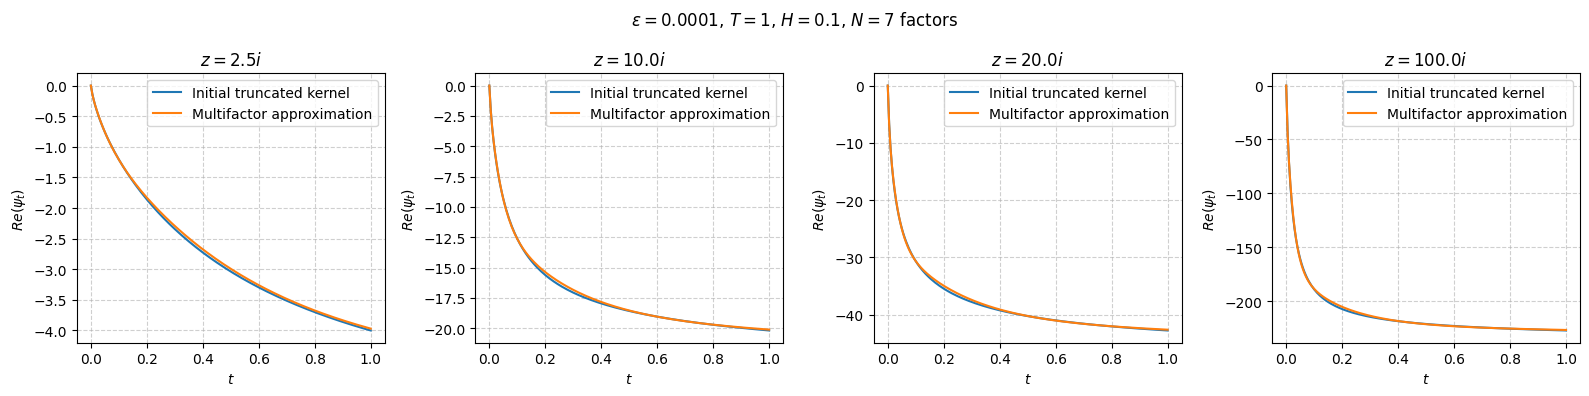

In [18]:
u_list = np.array([2.5, 10, 20, 100])
T = 1
eps = 1e-4
N = 7
H = 0.1
t = np.linspace(0, T, int(max(n_min, n*T))+1)
psi_t_list = Riccati_solver(1j*u_list, T, eps, False, N, H)[1]
psi_t_list_approx = Riccati_solver(1j*u_list, T, eps, True, N, H)[1] 
fig, axs = plt.subplots(1, len(u_list), figsize=(16, 4))
for i, u in enumerate(u_list):
    axs[i].plot(t, np.real(psi_t_list[i]), label=f'Initial truncated kernel')
    axs[i].plot(t, np.real(psi_t_list_approx[i]), label=f'Multifactor approximation')
    axs[i].set_xlabel(r"$t$")
    axs[i].set_ylabel(r"$Re(\psi_t)$")
    axs[i].set_title(f'$z = {u}i$')
    axs[i].grid(True, linestyle="--", alpha=0.6)
    axs[i].legend() 
plt.suptitle(f'$\\epsilon = {eps}$, $T={T}$, $H={H}$, $N={N}$ factors') 
plt.tight_layout()
plt.show()

##### **Comments:** 

- The multi factor modelling that we used seems to give a good approximation the the inial kernel since it ends up with similar solutions for $\psi(t)$

- We do not need too much factors (ie a large $N$) to have a good approximation when $\epsilon > 0$. In the suitable, we will use the initial kernel when $\epsilon > 0$ and the multi-factor approximation when $\epsilon = 0$

#### **Answer 2:** Implied volatility surface in Volterra Heston 

The **Characteristic function** in the Volterra Heston model is given by:

$$
\mathbb{E} \left[ e^{z \log S_T} \mid \mathcal{F}_t \right] = e^{z \log S_t + \int_t^T F(\psi)(T - s) g_t(s) \, ds}
$$
Where:

$$
\begin{aligned}
g_t(u)  &= \mathbb{E} \left[ V_u + \lambda \int_t^u V_s \, ds \mid \mathcal{F}_t \right] \\
        &= g_0(u) + \int_0^t K_{\epsilon}(u - s) \left( -\lambda V_s \, ds + \eta \sqrt{V_s} \, dW_s \right)
\end{aligned}
$$
With $g_0(u) = V_0 + \int_0^u K_{\epsilon}(u - s) \theta \, ds = V_0 + \frac{\theta}{H + \frac{1}{2}} \left[ (u+\epsilon)^{H+\frac{1}{2}} - \epsilon^{H+\frac{1}{2}} \right]$

In the following, we code for the case $t=0$. The Fourier transform of $\log(S_T)$ is then:

$$
\boxed{
\Phi^{volt}_T(z) = \mathbb{E} \left[ e^{i z \log S_T} \right] = e^{i z \log S_0 + \int_0^T F(\psi)(T - s) g_t(s) \, ds }}
$$

In [19]:
def g0(u, eps, H=H, V0=V0, theta=theta):
    alpha = H+0.5
    return V0 + theta * ((u+eps)**alpha - eps**alpha) / alpha


def Phi_Volt_Heston(z, T, eps, approx, N=N, H=H, V0=V0, S0=S0, lambd=lambd, rho=rho, eta=eta, n=n):
    """ Computes the Fourier transform of the log(S_T) """
    z = np.asarray(z)
    v = 1j*z
    t, psi_t = Riccati_solver(v, T, eps, approx, N, H, lambd, rho, eta, n)
    g = g0(t, eps, H, V0, theta)
    F_psi_inv = F_fun(psi_t[:,::-1], v[:, None], lambd, rho, eta)
    integral = np.trapz(F_psi_inv*g, t, axis=1)
    return np.exp( v*np.log(S0) + integral )

To compute the price under the Volterra-Heston model, we will still use the Lewis formula given in part 1 but using the corresponding Fourier transform.

In [20]:
def Put_price_lewis_Volt(T, K_val, eps=eps, approx=True, N=N, H=H, V0=V0, S0=S0, lambd=lambd, rho=rho, eta=eta, n=n):
    """ Compute the put price under the Volterra-Heston model using the Lewis formula """
    K_val = np.asarray(K_val)
    nb_points = 170
    z_i, w_i = np.polynomial.laguerre.laggauss(nb_points)
    char_hest_volt = Phi_Volt_Heston(z_i-0.5j, T, eps, approx, N, H, V0, S0, lambd, rho, eta, n)
    k_val = np.log(S0/K_val)
    integrand_hest_volt = np.real( np.exp(1j * z_i[None,:] * k_val[:,None]) * char_hest_volt[None:] ) / (z_i[None:]**2 + 1/4)
    return K_val - (np.sqrt(S0 * K_val) / np.pi) * np.sum(integrand_hest_volt*np.exp(z_i[None,:])*w_i[None,:], axis=1) 


def implied_vol_Volt(T, K_val, eps=eps, approx=True, N=N, H=H, r = 0.0, V0=V0, S0=S0, lambd=lambd, rho=rho, eta=eta, n=n):
    """ Computes the implied volatility under the Volterra-Heston model """
    K_val = np.asarray(K_val)
    put_volt_hest = Put_price_lewis_Volt(T, K_val, eps, approx, N, H, V0, S0, lambd, rho, eta, n)
    
    def objective(vol, K, put_price):
        return blackscholes_price(vol, T, K, S0, r, 'put') - put_price
    
    def solve_iv(K, put_price):
        try:
            return brentq(objective, 1e-6, 5, args=(K, put_price), xtol=1e-6, maxiter=200)
        except ValueError:
            return np.nan  
        
    return np.vectorize(solve_iv)(K_val, put_volt_hest)

Here, we plot implied volatilities curves for various $\epsilon$

In [21]:
eps_list = np.array([1e-6, 1e-7, 0.0])
N = 80
H = 0.1
approx = True
T_list = np.array([0.02, 0.04, 0.1, 0.25, 0.5, 1.])
K_list = np.linspace(np.exp(-0.5), np.exp(0.5), 40)
implied_vol_volt_list = np.array( [ [ implied_vol_Volt(T0, K_list, eps, approx, N, H) for T0 in T_list ] for eps in eps_list] )

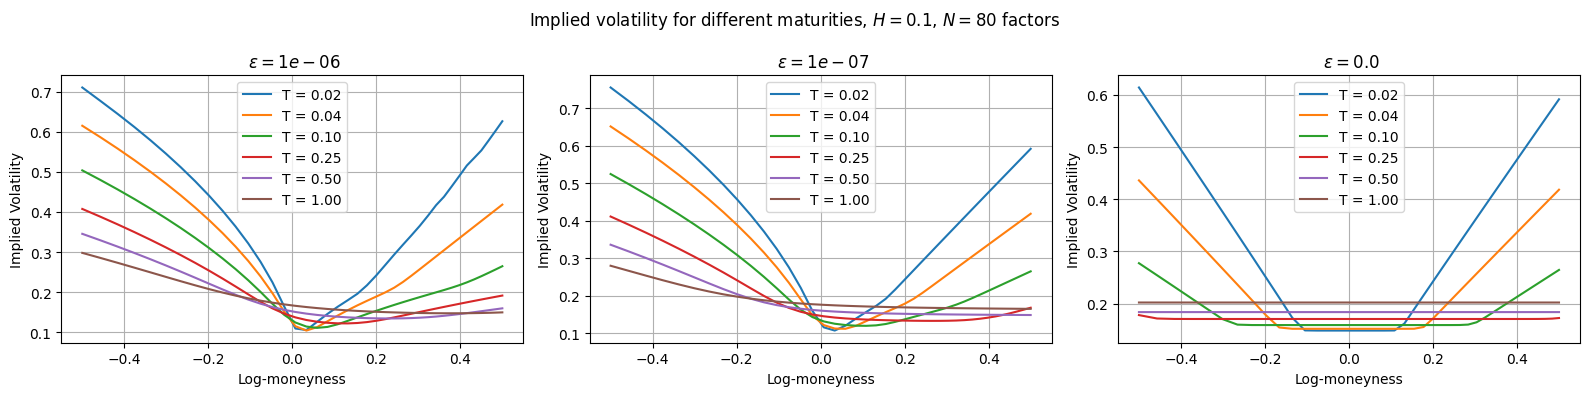

In [22]:
fig, axs = plt.subplots(1, len(eps_list), figsize=(16, 4))
for i, eps in enumerate(eps_list):
    for j, T0 in enumerate(T_list):
        vol_row = implied_vol_volt_list[i, j, :]
        valid = ~np.isnan(vol_row)
        if np.sum(valid) < 2:
            continue
        f_interp = interp1d(K_list[valid], vol_row[valid], kind='linear', bounds_error=False, fill_value="extrapolate")
        vol_interp = f_interp(K_list)
        axs[i].plot(np.log(K_list), vol_interp, label=f"T = {T0:.2f}")
    axs[i].set_xlabel("Log-moneyness")
    axs[i].set_ylabel("Implied Volatility")
    axs[i].set_title(f" $\\epsilon={eps}$")
    axs[i].legend()
    axs[i].grid(True) 
plt.suptitle(f'Implied volatility for different maturities, $H={H}$, $N={N}$ factors')
plt.tight_layout()
plt.show()


#### **Comments :**

- Very small but not null values of $\epsilon$ lead to coherent implied volaties with convexity as assymetry near ATM
- For $\epsilon = 0$, the smile is completely symetric and flat near ATM for short term maturities and completely flat for long term maturities.

#### **Answer 3:** $\epsilon =0$, Plots of the atm-skew for $T \in 0.02, ..., 1$ for varying $H$.

In [23]:
def skew_atm_Volt(T, eps, approx=True, N=N, H=H, r = 0.0, V0=V0, S0=S0, lambd=lambd, rho=rho, eta=eta, n=n, delta_x=1e-5):
    """ Compute the skew ATM under the Volterra Heston model """
    K_minus = S0 * np.exp(-delta_x) 
    K_plus = S0 * np.exp(delta_x)   
    sigma_minus_plus = implied_vol_Volt(T, [K_minus, K_plus], eps, approx, N, H, r, V0, S0, lambd, rho, eta, n)
    skew_atm = -(sigma_minus_plus[1] - sigma_minus_plus[0]) / (2 * delta_x)
    return skew_atm

In [ ]:
eps = 0.0
H_list = np.array([0.2, 0.1, 0.05, 0.01])
T_list = np.linspace(0.02, 1, 50)
approx = True
N = 80
skew_atm_volt_list_H = np.array( [ [ skew_atm_Volt(T0, eps, approx, N, H) for T0 in T_list ] for H in H_list] )

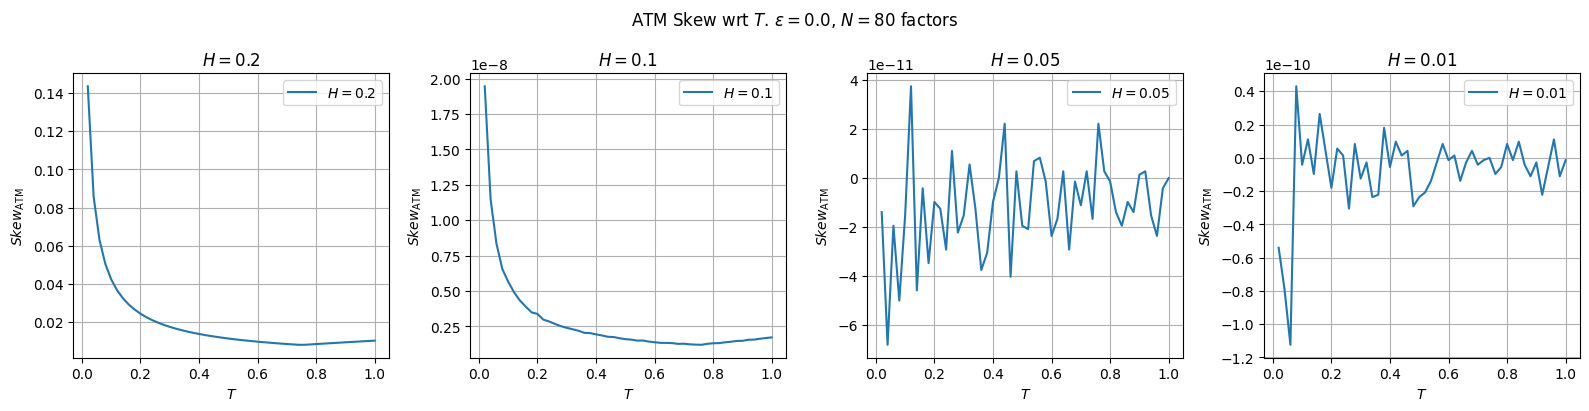

In [ ]:
fig, axs = plt.subplots(1, len(H_list), figsize=(16, 4.15))
for i, H in enumerate(H_list):
    axs[i].plot(T_list, skew_atm_volt_list_H[i], label=f"$H = {H}$")
    axs[i].set_title(f"$H = {H}$")
    axs[i].set_xlabel("$T$")
    axs[i].grid()
    axs[i].legend()
    axs[i].set_ylabel(r"$Skew_{\text{ATM}}$")
fig.suptitle(f"ATM Skew wrt $T$. $\\epsilon={eps}$, $N={N}$ factors")
plt.tight_layout()
plt.show()


#### **Comments :**

- The ATM skew globally decreases as $H$ decreases.
- When $\epsilon=0$, the skew is coherent for values of $H$ of order $\sim 0.1$ but less than $0.5$. For small values, some numerical instabilities are observed and the skew fluctuates.

#### **Answer 4:** $H = 0.01$, Plots of the atm-skew for $T \in 0.02, ..., 1$ for varying $\epsilon$.

In [ ]:
H = 0.01
eps_list = np.array([1e-5, 1e-6, 1e-7, 1e-8])
T_list = np.linspace(0.02, 1, 50)
approx = False
N = 80
skew_atm_volt_list_eps = np.array( [ [ skew_atm_Volt(T0, eps, approx, N, H) for T0 in T_list ] for eps in eps_list] )

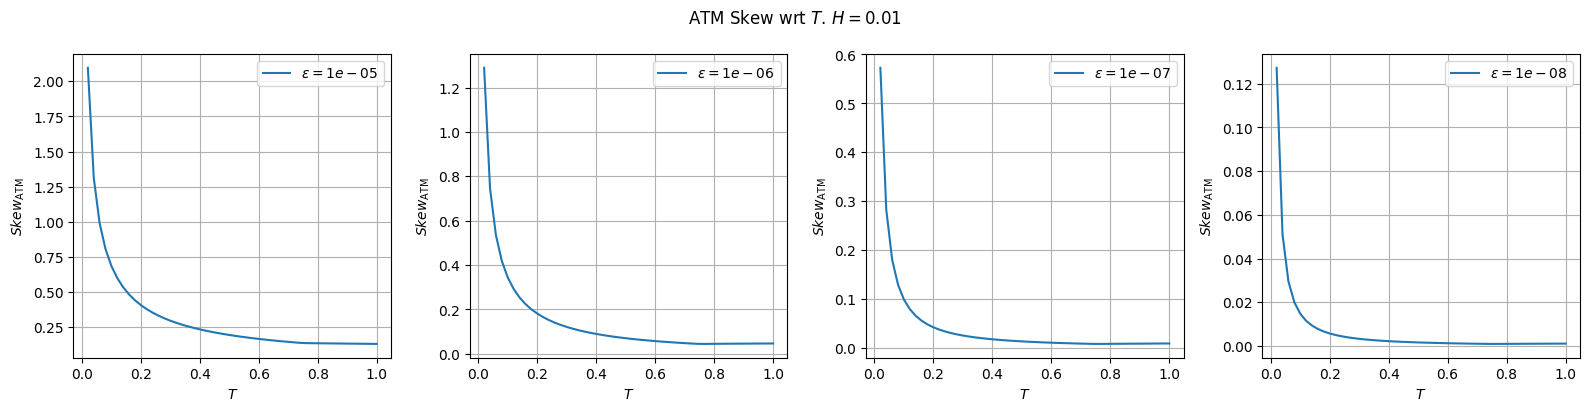

In [ ]:
fig, axs = plt.subplots(1, len(eps_list), figsize=(16, 4.15))
for i, eps in enumerate(eps_list):
    axs[i].plot(T_list, skew_atm_volt_list_eps[i], label=f"$\\epsilon = {eps}$")
    axs[i].set_xlabel("$T$")
    axs[i].grid()
    axs[i].legend()
    axs[i].set_ylabel(r"$Skew_{\text{ATM}}$")
fig.suptitle(f"ATM Skew wrt $T$. $H={H}$")
plt.tight_layout()
plt.show()


#### **Comments :**

For this choice of parameters, 

- we have a good shape of the skew which gloablly decrease as $\epsilon$ decreases. 

- It explodes at $T=0$ and decreases as a power law as $T$ encreases. 

Under the Volterra-Heston model, the long memory of volatility induced by the parameter $H$ slows down mean reversion, making volatility more persistent across different time scales. This reduces the impact of the correlation $\rho$ on instantaneous volatility fluctuations, leading to a more gradual decline of negative ATM skew with maturity, following a power-law behavior. Volterra-Heston better captures the autocorrelation effect of volatility observed in financial markets.

#### **Answer 5:** Best suited model for market data.

The **Volterra-Heston** model (with good parameters: $H \sim 0.01$ and $\epsilon>0$ but very small) is generally more appropriate for market data, especially for long maturities, as it better captures volatility memory and its empirically observed persistence. Unlike the classical Heston model, which assumes rapid mean reversion causing a **V-shaped** dynamic for the ATM skew, Volterra-Heston allows for a more gradual decay of ATM skew, aligning with market behavior where volatility exhibits significant autocorrelation across different time scales. This makes it particularly relevant for modeling market-implied volatility smiles, which do not flatten as quickly as predicted by the Heston model.